In [1]:
### Install Qiskit, if needed
%pip install -q qiskit[visualization]==1.0.2
%pip install -q qiskit-aer
%pip install -q qiskit-ibm-runtime
%pip install -q graphviz
%pip install -q qiskit-serverless -U
%pip install -q qiskit-transpiler-service -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━

In [2]:
# imports
import random
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal, MCXGate, MCMT, ZGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import random
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [3]:
def set_io_qubits(qubit_count):
  """Add the specified number of input and output qubits."""
  return QuantumCircuit(qubit_count + 1, qubit_count)

def make_oracle(circuit, qubit_count, x_bits):
  """Implement function {f(x) = 1 if x==x', f(x) = 0 if x!= x'}."""
  # Apply X gates to match x_bits
  for i in range(qubit_count):
    if x_bits[i] == 0:
      circuit.x(i)

  circuit.compose(MCMT(ZGate(), qubit_count - 1, 1), inplace=True)

  # Apply X gates to reset the original state
  for i in range(qubit_count):
    if x_bits[i] == 0:
      circuit.x(i)

def make_grover_circuit(qubit_count, x_bits):
  """Find the value recognized by the oracle in sqrt(N) attempts."""
  # Initialize circuit
  circuit = set_io_qubits(qubit_count)

  # Initialize qubits
  circuit.h(range(qubit_count))
  circuit.x(qubit_count)

  # Add oracle
  make_oracle(circuit, qubit_count, x_bits)

  # Grover operator (Diffusion operator)
  circuit.h(range(qubit_count))
  circuit.x(range(qubit_count))
  circuit.compose(MCMT(ZGate(), qubit_count - 1, 1), inplace=True)
  circuit.x(range(qubit_count))
  circuit.h(range(qubit_count))

  # Measure
  circuit.measure(range(qubit_count), range(qubit_count))
  return circuit

In [13]:
def main(results, output=False):
  qubit_count = 3
  circuit_sample_count = 512

  # Choose the x' and make an oracle which can recognize it.
  x_bits = [random.randint(0, 1) for _ in range(qubit_count)]
  rev_x_bits = x_bits[::-1]

  # Make Grover's circuit
  circuit = make_grover_circuit(qubit_count, rev_x_bits)

  # Simulate the circuit
  simulator = FakeSherbrooke()
  compiled_circuit = transpile(circuit, simulator, optimization_level=3)
  result = simulator.run(compiled_circuit, shots=circuit_sample_count).result()
  counts = result.get_counts()

  # Check if we actually found the secret value
  most_common_bitstring = max(counts, key=counts.get)

  # prints Z
  if (output == True):
    print('Secret bit sequence: {}'.format(x_bits))
    print('Circuit:')
    print(circuit)
    print('Sampled results:\n{}'.format(counts))
    print('Most common bitstring: {}'.format(most_common_bitstring))
    print('Found a match: {}'.format(
    most_common_bitstring == ''.join(map(str, x_bits))))
  else:
    results.append(most_common_bitstring == ''.join(map(str, x_bits)))


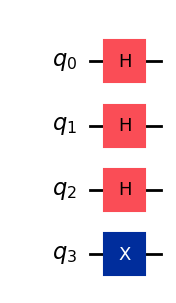

In [6]:
qubit_count = 3
qc = QuantumCircuit(qubit_count + 1)

### Initialized state example

qc.h(range(qubit_count))
qc.x(qubit_count)

qc.draw(output='mpl')

In [7]:
def check_accuracy(num_trials=10):
  results = []
  for _ in range(num_trials):
    main(results)

  count = 0
  for res in results:
    if res:
      count += 1

  print('Accuracy: {}'.format(count / len(results)))

In [16]:
if __name__ == '__main__':
  for i in range(5):
    results = []
    main(results, output=True)
    print('\n')

Secret bit sequence: [0, 1, 1]
Circuit:
     ┌───┐        ┌───┐┌───┐        ┌───┐┌───┐┌─┐      
q_0: ┤ H ├──────■─┤ H ├┤ X ├──────■─┤ X ├┤ H ├┤M├──────
     ├───┤      │ ├───┤├───┤      │ ├───┤├───┤└╥┘┌─┐   
q_1: ┤ H ├──────■─┤ H ├┤ X ├──────■─┤ X ├┤ H ├─╫─┤M├───
     ├───┤┌───┐ │ ├───┤├───┤┌───┐ │ ├───┤├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├─■─┤ X ├┤ H ├┤ X ├─■─┤ X ├┤ H ├─╫──╫─┤M├
     ├───┤└───┘   └───┘└───┘└───┘   └───┘└───┘ ║  ║ └╥┘
q_3: ┤ X ├─────────────────────────────────────╫──╫──╫─
     └───┘                                     ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2 
Sampled results:
{'000': 20, '010': 17, '100': 20, '001': 32, '101': 27, '111': 28, '011': 344, '110': 24}
Most common bitstring: 011
Found a match: True


Secret bit sequence: [0, 1, 1]
Circuit:
     ┌───┐        ┌───┐┌───┐        ┌───┐┌───┐┌─┐      
q_0: ┤ H ├──────■─┤ H ├┤ X ├──────■─┤ X ├┤ H ├┤M├──────
     ├───┤      │ ├───┤├───┤      │ 

In [19]:
# Runs a random circuit 10 times, this can be adjusted
# check_accuracy(100)
